In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/toddvansteenwyk/opt/anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.2                |           py37_0         3.0 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.

In [7]:
# Scrape post codes from web page
table = pd.read_html('https://www.milesfaster.co.uk/london-postcodes-list.htm')
print(table[0])

       0                                          1     2  \
0     E1             Whitechapel, Stepney, Mile End   SE1   
1    E1W                                    Wapping   SE2   
2     E2                  Bethnal Green, Shoreditch   SE3   
3     E3                        Bow, Bromley-by-Bow   SE4   
4     E4                    Chingford, Highams Park   SE5   
5     E5                                    Clapton   SE6   
6     E6                                   East Ham   SE7   
7     E7                    Forest Gate, Upton Park   SE8   
8     E8                           Hackney, Dalston   SE9   
9     E9                          Hackney, Homerton  SE10   
10   E10                                     Leyton  SE11   
11   E11                                Leytonstone  SE12   
12   E12                                 Manor Park  SE13   
13   E13                                   Plaistow  SE14   
14   E14  Poplar, Millwall, Isle of Dogs, Docklands  SE15   
15   E15                

In [25]:
#Rename the columns
df= pd.DataFrame(table[0])
df.rename(columns={0:'Postcode',1:'Area',2:'Postcode',3:'Area'},inplace=True)
df.head()

,Postcode,Area,Postcode,Area
0,E1,"Whitechapel, Stepney, Mile End",SE1,"Waterloo, Bermondsey, Southwark, Borough"
1,E1W,Wapping,SE2,Abbey Wood
2,E2,"Bethnal Green, Shoreditch",SE3,"Blackheath, Westcombe Park"
3,E3,"Bow, Bromley-by-Bow",SE4,"Brockley, Crofton Park, Honor Oak Park"
4,E4,"Chingford, Highams Park",SE5,Camberwell


In [28]:
#Slice the data frame
col1 = df.iloc[:,0:2]
col2 = df.iloc[:,2:4]
col2.head()

,Postcode,Area
0,SE1,"Waterloo, Bermondsey, Southwark, Borough"
1,SE2,Abbey Wood
2,SE3,"Blackheath, Westcombe Park"
3,SE4,"Brockley, Crofton Park, Honor Oak Park"
4,SE5,Camberwell


In [30]:
#Turn data frame into one that has just one column for postcode, one for area name
area = pd.concat([col1,col2])
area.shape

(128, 2)

In [32]:
#Drop rows without valid information
area.dropna(inplace=True)
area.shape

(121, 2)

In [39]:
#Export postcodes in excel format to use web tool to get corresponding geo coordinates
area['Postcode'].to_excel('desktop/postcodes.xlsx')

In [40]:
#import geo coordinates
geo = pd.read_excel('desktop/postcodes.xlsx')
geo.head()

,Postcode,Latitude,Longitude
0,E1,51.512497,-0.052098
1,E1W,51.505800,0.057200
2,E2,51.526024,-0.066917
3,E3,51.530230,-0.028907
4,E4,51.633250,0.008156


In [44]:
#Merge the geo data frame with the postcode/area data frame
pc_df = pd.merge(area,geo,on='Postcode',how='left')
pc_df.head()

,Postcode,Area,Latitude,Longitude
0,E1,"Whitechapel, Stepney, Mile End",51.512497,-0.052098
1,E1W,Wapping,51.505800,0.057200
2,E2,"Bethnal Green, Shoreditch",51.526024,-0.066917
3,E3,"Bow, Bromley-by-Bow",51.530230,-0.028907
4,E4,"Chingford, Highams Park",51.633250,0.008156


In [47]:
address = 'London, Greater London, England, UK'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


# Map of London with Areas superimposed

In [50]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, area in zip(pc_df['Latitude'], pc_df['Longitude'], pc_df['Area']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [51]:
CLIENT_ID = 'V0E1KPFSXJIAINRPDLYJHEBCAQXUI0VJALCVIULVDTOMC1EQ' #Foursquare ID
CLIENT_SECRET = '3CR3BMOARX1BZL1Q0YQONA5GGZGGWVQ2MAFDZFJTZESV4RFP' #Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: V0E1KPFSXJIAINRPDLYJHEBCAQXUI0VJALCVIULVDTOMC1EQ
CLIENT_SECRET:3CR3BMOARX1BZL1Q0YQONA5GGZGGWVQ2MAFDZFJTZESV4RFP


# Exploring Venues in different Areas of London

In [56]:
LIMIT = 50
radius = 500

def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [58]:
london_venues = getNearbyVenues(names=pc_df['Area'],
                                latitudes=pc_df['Latitude'],
                                longitudes=pc_df['Longitude']
                                )

Whitechapel, Stepney, Mile End
Wapping
Bethnal Green, Shoreditch
Bow, Bromley-by-Bow
Chingford, Highams Park
Clapton
East Ham
Forest Gate, Upton Park
Hackney, Dalston
Hackney, Homerton
Leyton
Leytonstone
Manor Park
Plaistow
Poplar, Millwall, Isle of Dogs, Docklands
Stratford, West Ham
Canning Town, North Woolwich, Docklands
Walthamstow
South Woodford
Olympic Park
Bloomsbury, Grays Inn
Covent Garden, Holborn, Strand
Clerkenwell, Finsbury, Barbican
Moorgate, Liverpool Street
Monument, Tower Hill, Aldgate
Fleet Street, St. Pauls
Islington, Barnsbury, Canonbury
East Finchley
Finchley Central
Finsbury Park, Manor House
Highbury
Highgate
Holloway
Hornsey, Crouch End
Lower Edmonton
Muswell Hill
Friern Barnet, New Southgate
North Finchley, Woodside Park
Palmers Green
Southgate
Seven Sisters
Stoke Newington, Stamford Hill
Tottenham
Upper Edmonton
Archway, Tufnell Park
Whetstone, Totteridge
Winchmore Hill
Wood Green, Alexandra Palace
Regents Park, Camden Town
Cricklewood, Neasden
Hampstead, Swis

In [59]:
print(london_venues.shape)
london_venues.head()

(2768, 7)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Whitechapel, Stepney, Mile End",51.512497,-0.052098,George Tavern,51.514223,-0.053258,Pub
1,"Whitechapel, Stepney, Mile End",51.512497,-0.052098,East London Food Centre,51.513591,-0.048786,Grocery Store
2,"Whitechapel, Stepney, Mile End",51.512497,-0.052098,King Edward Memorial Park,51.508957,-0.048895,Park
3,"Whitechapel, Stepney, Mile End",51.512497,-0.052098,St George's Leisure Centre,51.509930,-0.057905,Pool
4,"Whitechapel, Stepney, Mile End",51.512497,-0.052098,Sainsbury's Local,51.514305,-0.054450,Grocery Store


In [61]:
print('There are {} unique Venue Categories.'.format(len(london_venues['Venue Category'].unique())))

There are 297 unique Venue Categories.


# Area Analysis

In [64]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Area'] = london_venues['Area'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Area,ATM,African Restaurant,Airport Service,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Hill,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lawyer,Leather Goods Store,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Rugby Pitch,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Snack Place,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trai

In [65]:
london_onehot.shape

(2768, 298)

In [66]:
london_grouped = london_onehot.groupby('Area').mean().reset_index()
london_grouped.head()

,Area,ATM,African Restaurant,Airport Service,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Hill,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lawyer,Leather Goods Store,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Rugby Pitch,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Snack Place,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trai

In [67]:
london_grouped.shape

(120, 298)

In [68]:
#Sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [69]:
#Create dataframe and display top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
area_venues_sorted = pd.DataFrame(columns=columns)
area_venues_sorted['Area'] = london_grouped['Area']

for ind in np.arange(london_grouped.shape[0]):
    area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

area_venues_sorted.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Campground,Yoga Studio,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
1,Acton,Hotel,Coffee Shop,Gym,Grocery Store,Train Station,Fast Food Restaurant,Café,Park,Flea Market,Flower Shop
2,"Archway, Tufnell Park",Martial Arts Dojo,Wine Shop,Pub,Pizza Place,Yoga Studio,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
3,Balham,Italian Restaurant,Pub,Grocery Store,Pizza Place,Indian Restaurant,Gastropub,Wine Shop,Food Court,Food Stand,Food & Drink Shop
4,"Barnes, Castelnau",Pub,Grocery Store,Coffee Shop,Farmers Market,Park,Gastropub,Train Station,Tea Room,Athletics & Sports,Lake


# K-Means Clustering

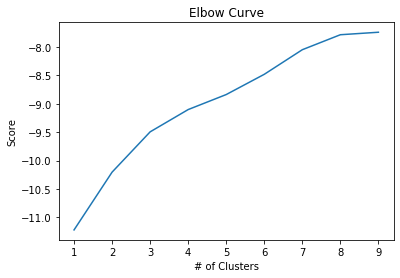

In [116]:
#Find out which is the best 'k'. After about 5 there seem to be no more big improvements
#for k in range (1,10):
 #   london_grouped_clustering = london_grouped.drop('Area',1)
 #   kmeans = KMeans(n_clusters = k, random_state = 0).fit(london_grouped_clustering)
  #  inertia = kmeans.inertia_
   # print('k: ',k,'   distance: ',inertia)

#Trying to use "elbow method" for determining best K, but not fantastic results
import matplotlib.pyplot as plt
Nc = range(1,10)
london_grouped_clustering = london_grouped.drop('Area',1)
k_means = [KMeans(n_clusters = i) for i in Nc]
k_means
score = [k_means[i].fit(london_grouped_clustering).score(london_grouped_clustering) for i in range(len(k_means))]
score
plt.plot(Nc,score)
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [74]:
#set number of clusters to 5, fit data, and cluster
london_grouped_clustering = london_grouped.drop('Area',1)
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(london_grouped_clustering)
labels = kmeans.labels_

In [82]:
#add clustering labels
area_venues_sorted.insert(0,'Cluster Labels',labels)

#merge venue, area, geo data with cluster labels
london_merged = pc_df.join(area_venues_sorted.set_index('Area'), on = 'Area')


In [84]:
london_merged.dropna(inplace=True)
london_merged.head(100)

,Postcode,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,E1,"Whitechapel, Stepney, Mile End",51.512497,-0.052098,4.0,Grocery Store,Park,Flower Shop,Sandwich Place,Harbor / Marina,Dive Bar,Coffee Shop,Hotel,Burger Joint,Pub
1,E1W,Wapping,51.505800,0.057200,0.0,Café,Tea Room,Airport Service,Light Rail Station,Coffee Shop,Flea Market,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop
2,E2,"Bethnal Green, Shoreditch",51.526024,-0.066917,0.0,Café,Pub,Yoga Studio,Restaurant,Turkish Restaurant,Coffee Shop,Furniture / Home Store,Bagel Shop,Bakery,Chocolate Shop
3,E3,"Bow, Bromley-by-Bow",51.530230,-0.028907,0.0,Pub,Café,Pizza Place,Grocery Store,Coffee Shop,Road,Bar,Bakery,Gift Shop,Turkish Restaurant
4,E4,"Chingford, Highams Park",51.633250,0.008156,0.0,Coffee Shop,Pub,Bakery,Grocery Store,Café,Italian Restaurant,Park,Food Court,Food & Drink Shop,Food Stand
5,E5,Clapton,51.557186,-0.049165,0.0,Grocery Store,Pub,Coffee Shop,Park,Convenience Store,Toy / Game Store,Intersection,Record Shop,Cocktail Bar,Dumpling Restaurant
6,E6,East Ham,51.537563,0.040294,4.0,Grocery Store,Bakery,Park,Market,Sandwich Place,Pub,Metro Station,Pharmacy,Farmers Market,Falafel Restaurant
7,E7,"Forest Gate, Upton Park",51.554412,0.019655,0.0,Bar,Wine Bar,Pub,Flower Shop,Restaurant,Fish & Chips Shop,Exhibit,Falafel Restaurant,Farm,Farmers Market
8,E8,"Hackney, Dalston",51.544454,-0.062790,0.0,Café,Italian Restaurant,Pub,Gym / Fitness Center,Train Station,Music Venue,Burger Joint,Brewery,Breakfast Spot,Modern European Restaurant
9,E9,"Hackney, Homerton",51.545421,-0.041952,0.0,Pub,Coffee Shop,Café,Yoga Studio,Train Station,Grocery Store,Garden,Food & Drink Shop,Fish & Chips Shop,Fast Food Restaurant


# Map with Clustered Areas of London

In [85]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)
kclusters = 5

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Area'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Area Analysis

In [107]:
# This cluster is interesting. Lots of parks and places to eat. Family-friendly comes to mind
cluster_4 = london_merged[london_merged['Cluster Labels']==4]
cluster_4.head(100)

,Postcode,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,E1,"Whitechapel, Stepney, Mile End",51.512497,-0.052098,4.0,Grocery Store,Park,Flower Shop,Sandwich Place,Harbor / Marina,Dive Bar,Coffee Shop,Hotel,Burger Joint,Pub
6,E6,East Ham,51.537563,0.040294,4.0,Grocery Store,Bakery,Park,Market,Sandwich Place,Pub,Metro Station,Pharmacy,Farmers Market,Falafel Restaurant
13,E13,Plaistow,51.529253,0.023155,4.0,Metro Station,Pub,Platform,Boutique,Park,Yoga Studio,Fish Market,Farm,Farmers Market,Fast Food Restaurant
36,N11,"Friern Barnet, New Southgate",51.615924,-0.134803,4.0,Pool,Grocery Store,Chinese Restaurant,Beer Bar,Park,Bus Stop,Food Stand,Food Court,Food & Drink Shop,Flower Shop
49,NW2,"Cricklewood, Neasden",51.562193,-0.213352,4.0,Gym / Fitness Center,Park,Breakfast Spot,Yoga Studio,Flea Market,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market
56,NW9,"Kinsbury, Colindale",51.584491,-0.260429,4.0,Park,Grocery Store,Playground,Bus Stop,Indian Restaurant,Office,Hookah Bar,Fish Market,Farm,Farmers Market
66,SE8,Deptford,51.486013,-0.031593,4.0,Park,Pub,Fast Food Restaurant,Vietnamese Restaurant,Food Court,Cosmetics Shop,Playground,Food & Drink Shop,Flower Shop,Food Stand
76,SE18,"Woolwich, Plumstead",51.484461,0.084733,4.0,Café,Park,Convenience Store,Pub,Grocery Store,Fish Market,Farm,Farmers Market,Fast Food Restaurant,Film Studio
80,SE22,East Dulwich,51.447688,-0.072271,4.0,Park,Pub,Grocery Store,Flower Shop,Yoga Studio,Fish & Chips Shop,Farm,Farmers Market,Fast Food Restaurant,Film Studio
82,SE24,Herne Hill,51.464009,-0.093150,4.0,Convenience Store,Pub,Park,Bus Stop,Hill,Food & Drink Shop,Athletics & Sports,Fish Market,Farm,Farmers Market


In [108]:
# Probably didn't need this cluster since only one area. Looks like a typical suburb or commuter area
cluster_3 = london_merged[london_merged['Cluster Labels']==3]
cluster_3.head(100)

,Postcode,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
86,SE28,Thamesmead,51.495614,0.098266,3.0,Grocery Store,Food & Drink Shop,Yoga Studio,Fish Market,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Flea Market


In [109]:
# Maybe didn't need this cluster since it's only 1 area. Appears rural, "outdoorsy"
cluster_2 = london_merged[london_merged['Cluster Labels']==2]
cluster_2.head(100)

,Postcode,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,SE2,Abbey Wood,51.481603,0.122712,2.0,Campground,Yoga Studio,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop


In [110]:
# This cluster seems to be touristy, lots of hotels
cluster_1 = london_merged[london_merged['Cluster Labels']==1]
cluster_1.head(100)

,Postcode,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,E10,Leyton,51.573046,-0.008800,1.0,Burger Joint,Coffee Shop,Park,Supermarket,Grocery Store,Hotel,Pub,Fast Food Restaurant,Farm,Sandwich Place
16,E16,"Canning Town, North Woolwich, Docklands",51.507713,0.022806,1.0,Hotel,Café,Sandwich Place,Chinese Restaurant,Pub,Convenience Store,Harbor / Marina,Burger Joint,Noodle House,Bridge
20,WC1,"Bloomsbury, Grays Inn",51.530700,-0.123100,1.0,Hotel,Burger Joint,Pub,Coffee Shop,Café,Modern European Restaurant,Bakery,Hotel Bar,Train Station,Souvenir Shop
21,WC2,"Covent Garden, Holborn, Strand",51.513100,-0.012210,1.0,Pizza Place,Grocery Store,Park,Bakery,Light Rail Station,Tunnel,Fried Chicken Joint,Market,English Restaurant,Steakhouse
23,EC2,"Moorgate, Liverpool Street",51.519900,-0.094500,1.0,Gym / Fitness Center,Coffee Shop,Food Truck,Indie Movie Theater,Hotel,Sushi Restaurant,Vietnamese Restaurant,Café,Salad Place,Pizza Place
24,EC3,"Monument, Tower Hill, Aldgate",51.508400,-0.125500,1.0,Hotel,Wine Bar,Theater,Steakhouse,Ice Cream Shop,Art Museum,Outdoor Sculpture,Church,Portuguese Restaurant,Gay Bar
25,EC4,"Fleet Street, St. Pauls",51.508400,-0.125500,1.0,Hotel,Wine Bar,Theater,Steakhouse,Ice Cream Shop,Art Museum,Outdoor Sculpture,Church,Portuguese Restaurant,Gay Bar
32,N7,Holloway,51.555344,-0.128713,1.0,Hotel,Bus Stop,Convenience Store,Tennis Court,School,Park,Construction & Landscaping,Gastropub,Bed & Breakfast,Fast Food Restaurant
37,N12,"North Finchley, Woodside Park",51.609953,-0.174837,1.0,Italian Restaurant,Gym / Fitness Center,Café,Supermarket,Hotel,Pub,Fast Food Restaurant,Bakery,Hardware Store,Mediterranean Restaurant
51,NW4,"Hendon, Brent Cross",51.592278,-0.221975,1.0,Chinese Restaurant,Grocery Store,Hotel,Café,Middle Eastern Restaurant,Park,Bagel Shop,Turkish Restaurant,Irish Pub,Fried Chicken Joint


In [111]:
# This cluster seems to be trendy, lively, lots of places to eat and meet
cluster_0 = london_merged[london_merged['Cluster Labels']==0]
cluster_0.head(100)

,Postcode,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,E1W,Wapping,51.505800,0.057200,0.0,Café,Tea Room,Airport Service,Light Rail Station,Coffee Shop,Flea Market,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop
2,E2,"Bethnal Green, Shoreditch",51.526024,-0.066917,0.0,Café,Pub,Yoga Studio,Restaurant,Turkish Restaurant,Coffee Shop,Furniture / Home Store,Bagel Shop,Bakery,Chocolate Shop
3,E3,"Bow, Bromley-by-Bow",51.530230,-0.028907,0.0,Pub,Café,Pizza Place,Grocery Store,Coffee Shop,Road,Bar,Bakery,Gift Shop,Turkish Restaurant
4,E4,"Chingford, Highams Park",51.633250,0.008156,0.0,Coffee Shop,Pub,Bakery,Grocery Store,Café,Italian Restaurant,Park,Food Court,Food & Drink Shop,Food Stand
5,E5,Clapton,51.557186,-0.049165,0.0,Grocery Store,Pub,Coffee Shop,Park,Convenience Store,Toy / Game Store,Intersection,Record Shop,Cocktail Bar,Dumpling Restaurant
7,E7,"Forest Gate, Upton Park",51.554412,0.019655,0.0,Bar,Wine Bar,Pub,Flower Shop,Restaurant,Fish & Chips Shop,Exhibit,Falafel Restaurant,Farm,Farmers Market
8,E8,"Hackney, Dalston",51.544454,-0.062790,0.0,Café,Italian Restaurant,Pub,Gym / Fitness Center,Train Station,Music Venue,Burger Joint,Brewery,Breakfast Spot,Modern European Restaurant
9,E9,"Hackney, Homerton",51.545421,-0.041952,0.0,Pub,Coffee Shop,Café,Yoga Studio,Train Station,Grocery Store,Garden,Food & Drink Shop,Fish & Chips Shop,Fast Food Restaurant
11,E11,Leytonstone,51.564032,0.008798,0.0,Grocery Store,Sandwich Place,Café,Pub,Platform,Coffee Shop,Metro Station,Chinese Restaurant,Music Venue,Thai Restaurant
12,E12,Manor Park,51.551892,0.046229,0.0,Gym / Fitness Center,Pub,Indian Restaurant,Train Station,Restaurant,Film Studio,Exhibit,Falafel Restaurant,Farm,Farmers Market
